In [1]:
import numpy as np
import pandas as pd
import scipy

from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
from statsmodels.stats.proportion import proportion_confint

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('data.csv', sep=',')

* id - идентификатор заявки на получение кредита на товар/услугу
* required_amt - запрошенная сумма кредита
* installment_flg - флаг промо продукта
* monthly_income_amt - ежемесячный доход заявителя
* age - возраст заявителя
* has_high_education_flg - наличие высшего образования
* approved_flg - одобрил ли банк заявку

In [3]:
df.sample(5)

,id,required_amt,installment_flg,monthly_income_amt,age,has_high_education_flg,approved_flg
7109,7110,47735.0,1,25000,20,0,0
148,149,70294.0,1,30000,24,1,0
2120,2121,19260.0,0,30000,44,0,1
807,808,55822.0,1,25000,25,0,0
181,182,20270.0,0,35000,51,1,0


# Домашнее задание

### На основе того же набора данных требуется
 
1. Построить предсказательные интервалы для ежемесячного дохода и запрошенной суммы (в предположении логнормальности)
2. Определить для каждого признака, разделяет ли он риски. Т.е. надо строить доверительные интервалы для **approved_flg** по каждому признаку. *Подсказка:* для бинарных признаков можно строить интервалы на разность долей, для вещественных признаков - используйте разбивки на бакеты (группы равного размера) и сравнивайте полученные интервалы между этими группами. Попробуйте визуализировать результаты (для вещественных признаков).
3. Введите бинарный признак (какая сумма больше - запрошенная или ежемесячная зарплата) - оцените точечно и интервально шансы (odds) одобрения в зависимости от этого признака $$\text{odds: } \frac{p}{1-p}$$ Постройте также интервал для отношения шансов на этих выборках. *Подсказка:* используйте бутстреп.
 

### Задание 1
#### Предсказательный интервал для ежемесячного дохода

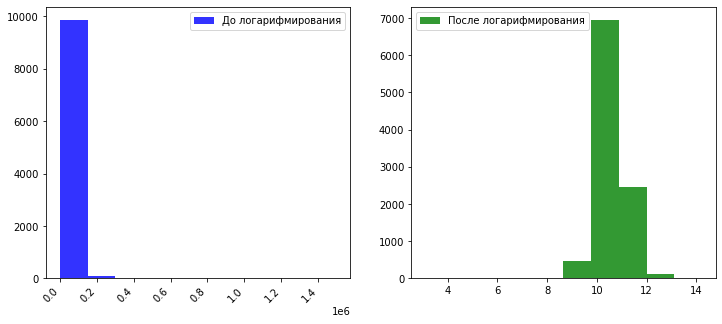

In [4]:
# Приведем данные к нормальному виду с помощью логарифмирования
monthly_income_amt = np.log(df['monthly_income_amt'])

# Посмотрим на гистограммы до и после логарифмирования
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(df['monthly_income_amt'],
           color = 'b',
           alpha = 0.8,
           label = 'До логарифмирования')
pylab.xticks(rotation=45, ha='right')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(monthly_income_amt,
           color = 'g',
           alpha = 0.8,
           label = 'После логарифмирования')
pylab.legend()

pylab.show()

In [5]:
monthly_income_amt_pred_int = _tconfint_generic(monthly_income_amt.mean(),
                                                monthly_income_amt.std(ddof=1),
                                                len(monthly_income_amt) - 1,
                                                0.05,
                                                'two-sided')

# Экспонируем полученные концы интервала, чтобы вернуться к привычным значениям amt
min_interval = np.exp(monthly_income_amt_pred_int[0])
max_interval = np.exp(monthly_income_amt_pred_int[1])

print(f'Monthly income amt 95% predictive interval: [{min_interval:.2f} - {max_interval:.2f}]')

Monthly income amt 95% predictive interval: [13006.90 - 119867.14]


#### Предсказательный интервал для запрошенной суммы

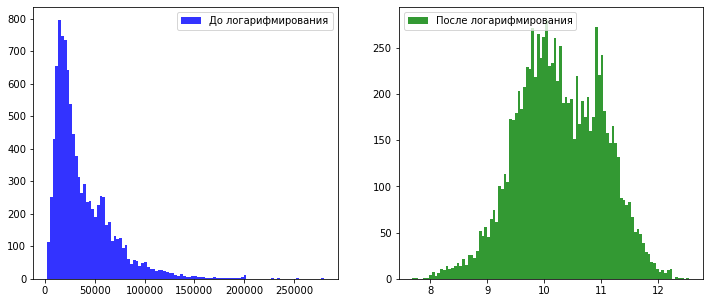

In [6]:
required_amt = np.log(df['required_amt'].dropna())

pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(df['required_amt'].dropna(),
           bins=100,
           color = 'b',
           alpha = 0.8,
           label = 'До логарифмирования')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(required_amt,
           bins=100,
           color = 'g',
           alpha = 0.8,
           label = 'После логарифмирования')
pylab.legend()

pylab.show()

In [7]:
required_amt_pred_int = _tconfint_generic(required_amt.mean(),
                                          required_amt.std(ddof=1),
                                          len(required_amt) - 1,
                                          0.05,
                                          'two-sided')

min_interval = np.exp(required_amt_pred_int[0])
max_interval = np.exp(required_amt_pred_int[1])

print(f'Required amt 95% predictive interval: [{min_interval:.2f} - {max_interval:.2f}]')

Required amt 95% predictive interval: [6676.43 - 124737.25]


### Задание 2

#### Доверительный интервал для разности долей одобренных заявок у пользователей с промо продуктом и без (не связные выборки)

$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

In [8]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.01):
    '''Считает доверительный интервал для разности долей в независимых выборках'''
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    sigma = np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    left_boundary = (p1 - p2) - z * sigma
    right_boundary = (p1 - p2) + z * sigma
    return (left_boundary, right_boundary)

In [9]:
proportions_confint_diff_ind(df[df.installment_flg == 1].approved_flg,
                             df[df.installment_flg == 0].approved_flg)

(-0.02488224598127247, 0.021904336839108467)

0 входит в интервал, значит наличие промо продукта не влияет на одобрение заявки

#### Доверительный интервал для разности долей одобренных заявок у пользователей с высшим образованием и без

In [10]:
proportions_confint_diff_ind(df[df.has_high_education_flg == 1].approved_flg,
                             df[df.has_high_education_flg == 0].approved_flg)

(0.07806537137828923, 0.1267927508516632)

Границы интервала лежат по правую сторону от 0, значит наличие высшего образования влияет на одобрение заявки


#### Доверительный интервал Уилсона

$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{
z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$ 

In [11]:
def wilson_conf_int(count, length):
    wilson_education_conf_int = proportion_confint(count,
                                               length,
                                               alpha = 0.01,
                                               method = 'wilson')
    print(f'99% confidence interval: [{wilson_education_conf_int[0]:.3f} - {wilson_education_conf_int[1]:.3f}]')

#### Интервал Уилсона для доли одобренных заявок у пользователей с определенной запрошенной суммой кредита

In [12]:
# Разобьем данные на 4 бакета в зависимости от значения квартиля
required_amt_approved1 = df[df.required_amt < df.required_amt.quantile(0.25)][['required_amt', 'approved_flg']]
required_amt_approved2 = df[(df.required_amt >= df.required_amt.quantile(0.25)) & (df.required_amt < df.required_amt.quantile(0.5))][['required_amt', 'approved_flg']]
required_amt_approved3 = df[(df.required_amt >= df.required_amt.quantile(0.5)) & (df.required_amt < df.required_amt.quantile(0.75))][['required_amt', 'approved_flg']]
required_amt_approved4 = df[df.required_amt >= df.required_amt.quantile(0.75)][['required_amt', 'approved_flg']]

In [13]:
wilson_conf_int(required_amt_approved1.approved_flg.sum(), len(required_amt_approved1.approved_flg))
wilson_conf_int(required_amt_approved2.approved_flg.sum(), len(required_amt_approved2.approved_flg))
wilson_conf_int(required_amt_approved3.approved_flg.sum(), len(required_amt_approved3.approved_flg))
wilson_conf_int(required_amt_approved4.approved_flg.sum(), len(required_amt_approved4.approved_flg))


99% confidence interval: [0.322 - 0.371]
99% confidence interval: [0.265 - 0.311]
99% confidence interval: [0.233 - 0.278]
99% confidence interval: [0.139 - 0.176]


Интервалы не пересекаются, значит запрошенная сумма кредита влияет на одобрение

#### Интервал Уилсона для доли одобренных заявок у пользователей с определенным ежемесячным доходом заявителя

In [14]:
monthly_income_amt_approved1 = df[df.monthly_income_amt < df.monthly_income_amt.quantile(0.25)][['monthly_income_amt', 'approved_flg']]
monthly_income_amt_approved2 = df[(df.monthly_income_amt >= df.monthly_income_amt.quantile(0.25)) \
        & (df.monthly_income_amt < df.monthly_income_amt.quantile(0.5))][['monthly_income_amt', 'approved_flg']]
monthly_income_amt_approved3 = df[(df.monthly_income_amt >= df.monthly_income_amt.quantile(0.5)) \
        & (df.monthly_income_amt < df.monthly_income_amt.quantile(0.75))][['monthly_income_amt', 'approved_flg']]
monthly_income_amt_approved4 = df[df.monthly_income_amt >= df.monthly_income_amt.quantile(0.75)][['monthly_income_amt', 'approved_flg']]

In [15]:
wilson_conf_int(monthly_income_amt_approved1.approved_flg.sum(), len(monthly_income_amt_approved1.approved_flg))
wilson_conf_int(monthly_income_amt_approved2.approved_flg.sum(), len(monthly_income_amt_approved2.approved_flg))
wilson_conf_int(monthly_income_amt_approved3.approved_flg.sum(), len(monthly_income_amt_approved3.approved_flg))
wilson_conf_int(monthly_income_amt_approved4.approved_flg.sum(), len(monthly_income_amt_approved4.approved_flg))

99% confidence interval: [0.251 - 0.298]
99% confidence interval: [0.231 - 0.275]
99% confidence interval: [0.238 - 0.283]
99% confidence interval: [0.237 - 0.282]


Интервалы пересекаются, значит ежемесячный доход не влияет на одобрение заявки

#### Интервал Уилсона для доли одобренных заявок у пользователей с определенным возрастом

In [16]:
age_approved1 = df[df.age < df.age.quantile(0.25)][['age', 'approved_flg']]
age_approved2 = df[(df.age >= df.age.quantile(0.25)) & (df.age < df.age.quantile(0.5))][['age', 'approved_flg']]
age_approved3 = df[(df.age >= df.age.quantile(0.5)) & (df.age < df.age.quantile(0.75))][['age', 'approved_flg']]
age_approved4 = df[df.age >= df.age.quantile(0.75)][['age', 'approved_flg']]

In [17]:
wilson_conf_int(age_approved1.approved_flg.sum(), len(age_approved1.approved_flg))
wilson_conf_int(age_approved2.approved_flg.sum(), len(age_approved2.approved_flg))
wilson_conf_int(age_approved3.approved_flg.sum(), len(age_approved3.approved_flg))
wilson_conf_int(age_approved4.approved_flg.sum(), len(age_approved4.approved_flg))

99% confidence interval: [0.091 - 0.123]
99% confidence interval: [0.200 - 0.243]
99% confidence interval: [0.289 - 0.336]
99% confidence interval: [0.369 - 0.418]


Интервалы не пересекаются, значит возраст заявителя влияет на одобрение заявки

### Задание 3

Введите бинарный признак (какая сумма больше - запрошенная или ежемесячная зарплата) - оцените точечно и интервально шансы (odds) одобрения в зависимости от этого признака $$\text{odds: } \frac{p}{1-p}$$ Постройте также интервал для отношения шансов на этих выборках. *Подсказка:* используйте бутстреп.
 

In [18]:
# Введем бинарный признак (какая сумма больше - запрошенная или ежемесячная зарплата) 
df.loc[df['required_amt'] < df['monthly_income_amt'], 'required_lower_monthly_flg'] = 1
df.loc[df['required_amt'] >= df['monthly_income_amt'], 'required_lower_monthly_flg'] = 0
df.head()

,id,required_amt,installment_flg,monthly_income_amt,age,has_high_education_flg,approved_flg,required_lower_monthly_flg
0,1,23906.0,0,80000,37,0,0,1.0
1,2,13111.0,1,43000,22,0,0,1.0
2,3,43266.0,1,20000,34,0,0,0.0
3,4,68782.0,1,35000,24,0,0,0.0
4,5,19550.0,1,25000,42,1,0,1.0


#### Точечно оценим шансы одобрения в зависимости от того, какая сумма больше

In [19]:
req_lower_monthly_len = len(df[df.required_lower_monthly_flg == 1])
req_more_monthly_len = len(df[df.required_lower_monthly_flg == 0])

required_lower_monthly_share = df[df.required_lower_monthly_flg == 1].approved_flg.sum() \
                                                    / req_lower_monthly_len

required_more_monthly_share = df[df.required_lower_monthly_flg == 0].approved_flg.sum() \
                                                    / req_more_monthly_len


required_lower_monthly_odds = required_lower_monthly_share / (1 - required_lower_monthly_share)
required_more_monthly_odds = required_more_monthly_share / (1 - required_more_monthly_share)

print('Шансы одобрения, когда месячный доход больше запрошенной суммы:', required_lower_monthly_odds)
print('Шансы одобрения, когда месячный доход меньше запрошенной суммы:', required_more_monthly_odds)

Шансы одобрения, когда месячный доход больше запрошенной суммы: 0.43467829880043624
Шансы одобрения, когда месячный доход меньше запрошенной суммы: 0.21968616262482166


#### Построим на этих выборках с помощью бутстрепа интервалы для шансов и их отношения

In [20]:
def get_bootstrap_samples(data, n_samples):
    '''Генерирует заданное кол-во (n_samples) выборок, равных по размеру исходной выборке'''
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [21]:
def get_stat_intervals(stat, alpha):
    '''Для заданной выборки возвращает двусторонний доверительный интервал [aplpha/2, 1 - alpha/2]'''
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [22]:
np.random.seed(0)

req_lower_monthly_atm = list(map(np.sum, get_bootstrap_samples(df[df.required_lower_monthly_flg == 1]\
                                                               .approved_flg.values, 1000)))

req_more_monthly_atm = list(map(np.sum, get_bootstrap_samples(df[df.required_lower_monthly_flg == 0]\
                                                              .approved_flg.values, 1000)))

req_lower_monthly_odds = [(x/req_lower_monthly_len) / (1 - x/req_lower_monthly_len) for x in req_lower_monthly_atm]
req_more_monthly_odds = [(x/req_more_monthly_len) / (1 - x/req_more_monthly_len) for x in req_more_monthly_atm]
ratio_odds = [req_lower_monthly_odds[i] / req_more_monthly_odds[i] for i in range(len(req_lower_monthly_odds))]

print('99% доверителный интервал шансов одобрения, когда месячный доход больше запрошенной суммы:', \
      get_stat_intervals(req_lower_monthly_odds, 0.01))
print('99% доверителный интервал шансов одобрения, когда месячный доход меньше запрошенной суммы:', \
      get_stat_intervals(req_more_monthly_odds, 0.01))
print('99% доверителный интервал отношения шансов одобрения:', \
      get_stat_intervals(ratio_odds, 0.01))

99% доверителный интервал шансов одобрения, когда месячный доход больше запрошенной суммы: [0.40826074 0.46406172]
99% доверителный интервал шансов одобрения, когда месячный доход меньше запрошенной суммы: [0.19622246 0.24545019]
99% доверителный интервал отношения шансов одобрения: [1.74344393 2.2488697 ]


Интервалы не пересекаются, разница лежит по правую сторону от 0. Значит разница между запрошенной суммой и месячным доходом влияет на одобрение заявки